7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
FNN MSE: 0.002542672025201755
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
LSTM MSE: 0.0020372553048162096
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
CNN MSE: 0.004205452893559357
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
TCN MSE: 0.0392064521245356
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Transformer MSE: 0.0044614081062748995


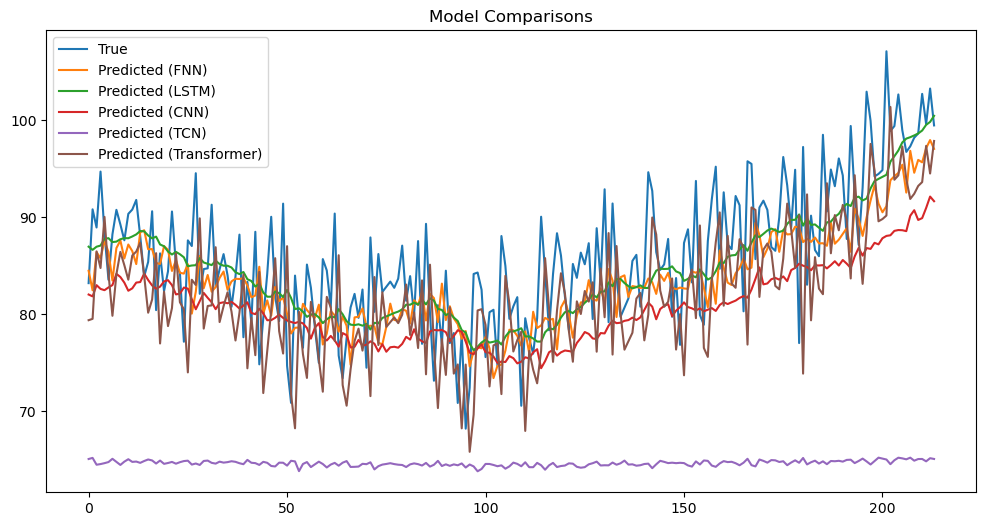

FNN MSE: 0.003
LSTM MSE: 0.002
CNN MSE: 0.004
TCN MSE: 0.039
Transformer MSE: 0.004


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf

# Generate synthetic time series data
np.random.seed(42)
date_rng = pd.date_range(start='2020-01-01', end='2022-12-31', freq='D')
n = len(date_rng)
trend = np.linspace(0, 100, n)
seasonality = 10 * np.sin(2 * np.pi * np.arange(n)/365.25)
noise = np.random.normal(0, 5, n)
y = trend + seasonality + noise

df = pd.DataFrame(data={'date': date_rng, 'value': y})
## Feedforward Neural Networks: The Baseline
def prepare_data(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i+n_steps])
        y.append(data[i+n_steps])
    return np.array(X), np.array(y)

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['value']])

# Prepare data for FNN
n_steps = 30
X, y = prepare_data(scaled_data, n_steps)

# Split into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build FNN model

model_fnn = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(n_steps, 1)),  
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

model_fnn.compile(optimizer='adam', loss='mse')
history_fnn = model_fnn.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

# Evaluate FNN
y_pred_fnn = model_fnn.predict(X_test)
mse_fnn = mean_squared_error(y_test, y_pred_fnn)
print(f"FNN MSE: {mse_fnn}")
## Long Short-Term Memory (LSTM): Capturing Long-Range Dependencies
# Reshape input for LSTM
X_train_lstm = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_lstm = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build LSTM model
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(n_steps, 1)),  
    tf.keras.layers.LSTM(50, activation='relu'),
    tf.keras.layers.Dense(1)
])


model_lstm.compile(optimizer='adam', loss='mse')
history_lstm = model_lstm.fit(X_train_lstm, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

# Evaluate LSTM
y_pred_lstm = model_lstm.predict(X_test_lstm)
mse_lstm = mean_squared_error(y_test, y_pred_lstm)
print(f"LSTM MSE: {mse_lstm}")
## Convolutional Neural Networks (CNN): Capturing Local Patterns
# Build CNN model
model_cnn = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(n_steps, 1)),  
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(1)
])

model_cnn.compile(optimizer='adam', loss='mse')
history_cnn = model_cnn.fit(X_train_lstm, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

# Evaluate CNN
y_pred_cnn = model_cnn.predict(X_test_lstm)
mse_cnn = mean_squared_error(y_test, y_pred_cnn)
print(f"CNN MSE: {mse_cnn}")
## Temporal Convolutional Networks (TCN): Combining CNN and RNN Strengths
from tensorflow.keras.layers import Conv1D, Dense, Dropout, LayerNormalization

def residual_block(x, dilation_rate, filters):
    skip = x
    x = Conv1D(filters, kernel_size=3, dilation_rate=dilation_rate, padding='causal', activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Conv1D(filters, kernel_size=3, dilation_rate=dilation_rate, padding='causal', activation='relu')(x)
    x = Dropout(0.4)(x)
    x = LayerNormalization()(x + skip)
    return x

# Build TCN model
inputs = tf.keras.layers.Input(shape=(n_steps, 1))  
x = inputs
for i in range(4):
    x = residual_block(x, dilation_rate=2**i, filters=64)
x = Dense(1)(x[:, -1, :])
model_tcn = tf.keras.Model(inputs, x)

model_tcn.compile(optimizer='adam', loss='mse')
history_tcn = model_tcn.fit(X_train_lstm, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

# Evaluate TCN
y_pred_tcn = model_tcn.predict(X_test_lstm)
mse_tcn = mean_squared_error(y_test, y_pred_tcn)
print(f"TCN MSE: {mse_tcn}")
## Transformer: Attention-based Sequence Modeling
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Dense


def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = Dropout(dropout)(x)
    x = LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs
    
    x = Dense(ff_dim, activation="relu")(res)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    x = LayerNormalization(epsilon=1e-6)(x)
    return x + res

# Build Transformer model
inputs = tf.keras.Input(shape=(n_steps, 1))
x = inputs
for _ in range(4):
    x = transformer_encoder(x, head_size=256, num_heads=4, ff_dim=4, dropout=0.1)
x = Dense(1)(x[:, -1, :])
model_transformer = tf.keras.Model(inputs, x)

model_transformer.compile(optimizer='adam', loss='mse')
history_transformer = model_transformer.fit(X_train_lstm, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

# Evaluate Transformer
y_pred_transformer = model_transformer.predict(X_test_lstm)
mse_transformer = mean_squared_error(y_test, y_pred_transformer)
print(f"Transformer MSE: {mse_transformer}")
## Comparative Analysis
def plot_predictions(true, predictions, title):
    plt.figure(figsize=(12, 6))
    plt.plot(true, label='True')
    for name, pred in predictions.items():
        plt.plot(pred, label=f'Predicted ({name})')
    plt.title(title)
    plt.legend()
    plt.savefig(f"{title}.png")
    plt.show()

# Inverse transform predictions
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_fnn_inv = scaler.inverse_transform(y_pred_fnn)
y_pred_lstm_inv = scaler.inverse_transform(y_pred_lstm)
y_pred_cnn_inv = scaler.inverse_transform(y_pred_cnn)
y_pred_tcn_inv = scaler.inverse_transform(y_pred_tcn)
y_pred_transformer_inv = scaler.inverse_transform(y_pred_transformer)

# Plot predictions
predictions = {
    'FNN': y_pred_fnn_inv,
    'LSTM': y_pred_lstm_inv,
    'CNN': y_pred_cnn_inv,
    'TCN': y_pred_tcn_inv,
    'Transformer': y_pred_transformer_inv
}
plot_predictions(y_test_inv, predictions, 'Model Comparisons')

# Compare MSE
mse_scores = {
    'FNN': mse_fnn,
    'LSTM': mse_lstm,
    'CNN': mse_cnn,
    'TCN': mse_tcn,
    'Transformer': mse_transformer
}
for model, mse in mse_scores.items():
    print(f"{model} MSE: {mse:.3f}")

In [ ]:
## Transformer: Attention-based Sequence Modeling
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Dense


def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = Dropout(dropout)(x)
    x = LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs
    
    x = Dense(ff_dim, activation="relu")(res)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    x = LayerNormalization(epsilon=1e-6)(x)
    return x + res

# Build Transformer model
inputs = tf.keras.Input(shape=(n_steps, 1))
x = inputs
for _ in range(4):
    x = transformer_encoder(x, head_size=256, num_heads=4, ff_dim=4, dropout=0.1)
x = Dense(1)(x[:, -1, :])
model_transformer = tf.keras.Model(inputs, x)

model_transformer.compile(optimizer='adam', loss='mse')
history_transformer = model_transformer.fit(X_train_lstm, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

# Evaluate Transformer
y_pred_transformer = model_transformer.predict(X_test_lstm)
mse_transformer = mean_squared_error(y_test, y_pred_transformer)
print(f"Transformer MSE: {mse_transformer}")


In [ ]:

# Compare MSE
mse_scores = {
    'FNN': mse_fnn,
    'LSTM': mse_lstm,
    'CNN': mse_cnn,
    'TCN': mse_tcn,
    'Transformer': mse_transformer
}
for model, mse in mse_scores.items():
    print(f"{model} MSE: {mse:.4f}")

In [ ]:
# Convert predictions and true values to DataFrame for easier resampling
df_results = pd.DataFrame({
    'date': df['date'][-len(y_test_inv):],  # Match the test set dates
    'true': y_test_inv.flatten(),
    'FNN': y_pred_fnn_inv.flatten(),
    'LSTM': y_pred_lstm_inv.flatten(),
    'CNN': y_pred_cnn_inv.flatten(),
    'TCN': y_pred_tcn_inv.flatten(),
    'Transformer': y_pred_transformer_inv.flatten()
})

# Set the 'date' column as the index
df_results.set_index('date', inplace=True)

# Resample to a weekly average
df_resampled = df_results.resample('W').mean()

# Plot the resampled predictions
def plot_resampled_predictions(resampled_df, title):
    plt.figure(figsize=(12, 6))
    plt.plot(resampled_df['true'], label='True', linewidth=2)
    for col in resampled_df.columns:
        if col != 'true':
            plt.plot(resampled_df[col], label=f'Predicted ({col})', alpha=0.8)
    plt.title(title)
    plt.legend()
    plt.show()

plot_resampled_predictions(df_resampled, 'Model Comparisons (Weekly Resampled)')


/var/folders/c8/g7bx7g1552g19xn4q4dd583r0000gn/T/ipykernel_55400/2110764199.py:18: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_resampled = df.resample('H').mean()
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential

Training FNN...
Training LSTM...
Training CNN...
Training TCN...
Evaluating FNN...
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Evaluating LSTM...
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Evaluating CNN...
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Evaluating TCN...
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


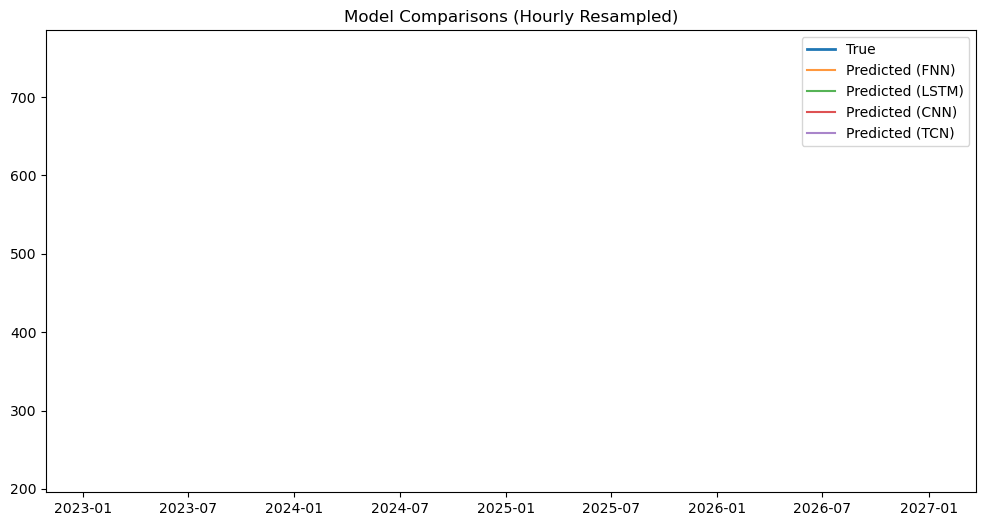

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf

# Load data
df = pd.read_csv("ercot_load_data.csv")
df['date'] = pd.to_datetime(df['date'])
df.set_index("date", inplace=True)
df.sort_index(inplace=True)
df = df[df['values'] >= 60]  # Filter out invalid values
values = df['values']
dates = df.index

# Resample the data to hourly for modeling
df_resampled = df.resample('H').mean()

# Normalize the data
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(df_resampled[['values']])

# Prepare data for time series modeling
def prepare_data(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i + n_steps])
        y.append(data[i + n_steps])
    return np.array(X), np.array(y)

# Set parameters
n_steps = 48  # For 48 hours (2 days) of history
X, y = prepare_data(scaled_values, n_steps)

# Split into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape for LSTM and CNN models
X_train_lstm = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_lstm = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Define a helper function to plot predictions
def plot_predictions(true, predictions, title, resample_freq='D'):
    # Resample to smooth out noise
    df_results = pd.DataFrame({'date': dates[-len(true):], 'true': true.flatten()})
    for name, pred in predictions.items():
        df_results[name] = pred.flatten()
    df_results.set_index('date', inplace=True)
    df_resampled = df_results.resample(resample_freq).mean()

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(df_resampled['true'], label='True', linewidth=2)
    for name in predictions.keys():
        plt.plot(df_resampled[name], label=f'Predicted ({name})', alpha=0.8)
    plt.title(title)
    plt.legend()
    plt.savefig("Plot.png")
    plt.show()

# Build and train all models
models = {
    'FNN': tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(n_steps, 1)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1)
    ]),
    'LSTM': tf.keras.Sequential([
        tf.keras.layers.LSTM(50, activation='relu', input_shape=(n_steps, 1)),
        tf.keras.layers.Dense(1)
    ]),
    'CNN': tf.keras.Sequential([
        tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_steps, 1)),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(50, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
}

# Add TCN model
from tensorflow.keras.layers import Conv1D, Dense, Dropout, LayerNormalization
def build_tcn(input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    x = inputs
    for i in range(4):
        x = residual_block(x, dilation_rate=2**i, filters=64)
    x = Dense(1)(x[:, -1, :])
    return tf.keras.Model(inputs, x)

def residual_block(x, dilation_rate, filters):
    skip = x
    x = Conv1D(filters, kernel_size=3, dilation_rate=dilation_rate, padding='causal', activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Conv1D(filters, kernel_size=3, dilation_rate=dilation_rate, padding='causal', activation='relu')(x)
    x = Dropout(0.1)(x)
    x = LayerNormalization()(x + skip)
    return x

models['TCN'] = build_tcn((n_steps, 1))

# Compile all models
for name, model in models.items():
    model.compile(optimizer='adam', loss='mse')

# Train models
histories = {}
for name, model in models.items():
    print(f"Training {name}...")
    history = model.fit(
        X_train_lstm, y_train,
        epochs=20, batch_size=32,
        validation_split=0.2, verbose=0
    )
    histories[name] = history

# Evaluate models
predictions = {}
for name, model in models.items():
    print(f"Evaluating {name}...")
    y_pred = model.predict(X_test_lstm)
    predictions[name] = scaler.inverse_transform(y_pred)

# Plot predictions
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
plot_predictions(y_test_inv, predictions, "Model Comparisons (Hourly Resampled)")


In [ ]:
# Prepare resampled data and ensure proper alignment
def plot_predictions(true, predictions, title, resample_freq='D'):
    # Create DataFrame for plotting
    df_results = pd.DataFrame({'date': dates[-len(true):], 'true': true.flatten()})
    for name, pred in predictions.items():
        df_results[name] = pred.flatten()

    # Debug: Print the initial df_results
    print("Initial df_results:\n", df_results.head())

    # Set the 'date' column as the index and resample
    df_results.set_index('date', inplace=True)
    df_resampled = df_results.resample(resample_freq).mean()

    # Debug: Print the resampled data
    print("Resampled Data:\n", df_resampled.head())

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(df_resampled['true'], label='True', linewidth=2)
    for name in predictions.keys():
        plt.plot(df_resampled[name], label=f'Predicted ({name})', alpha=0.8)
    plt.title(title)
    plt.legend()
    plt.xlabel("Date")
    plt.ylabel("Values")
    plt.grid()
    plt.show()

# Evaluate models and plot predictions
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
plot_predictions(y_test_inv, predictions, "Model Comparisons (Resampled to Daily)", resample_freq='D')
